In [35]:
import re
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

from Data import *
from Models import *
from utils import *

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
emotiondataset = EmotionDataset(batch_size=20)
train_iter, test_iter, train0_iter, sup_iter, noval_iter, idx2label, label2idx, labelvec, sup_labels, noval_labels = emotiondataset.get_iters()

classees of train_0: anger, fear, joy, love, sadness
classees of support: anger, fear, joy, love, sadness
classees of noval:    disgust, guilt, shame, surprise


In [4]:
trainer = Trainer(labelvec,sup_labels, noval_labels, device)
trainer = trainer.to(device)
record = Record()

## Train Text DeVise on various settings

In [5]:
model =MLP().to(device)
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 50
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

0.23482733964920044 


In [8]:
model =MLP().to(device)
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 50
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

0.2447362095117569  


In [11]:
model =MLP().to(device)
lr = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 50
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

0.23000413179397583 


In [51]:
model =MLP().to(device)
lr = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 50
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

In [17]:
model =MLP().to(device)
lr = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 50
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

0.22615504264831543 


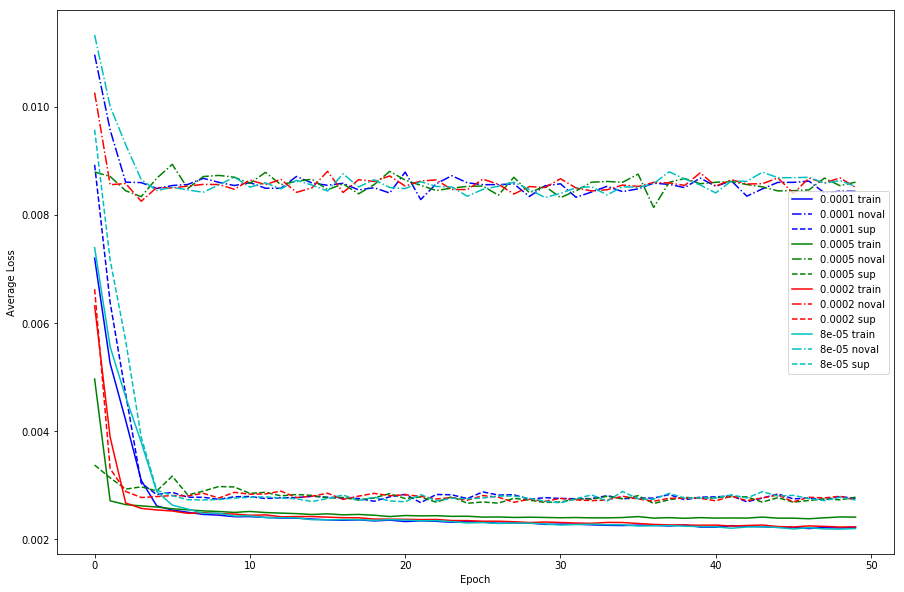

In [15]:
plot_loss(record)

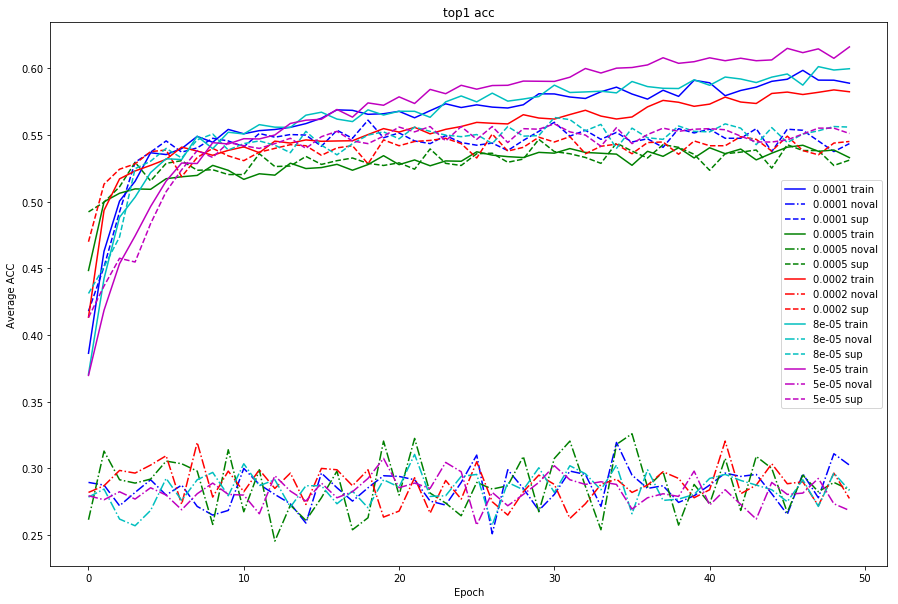

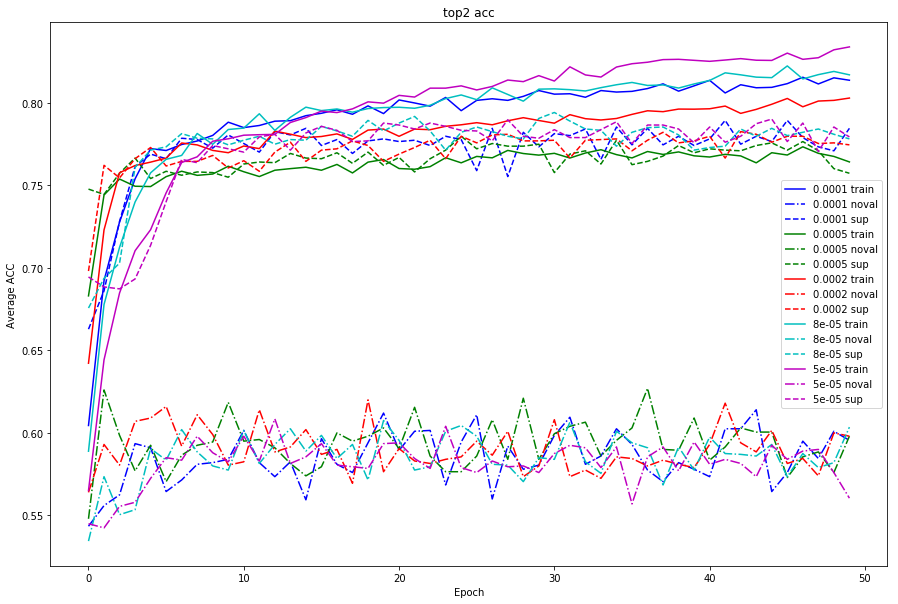

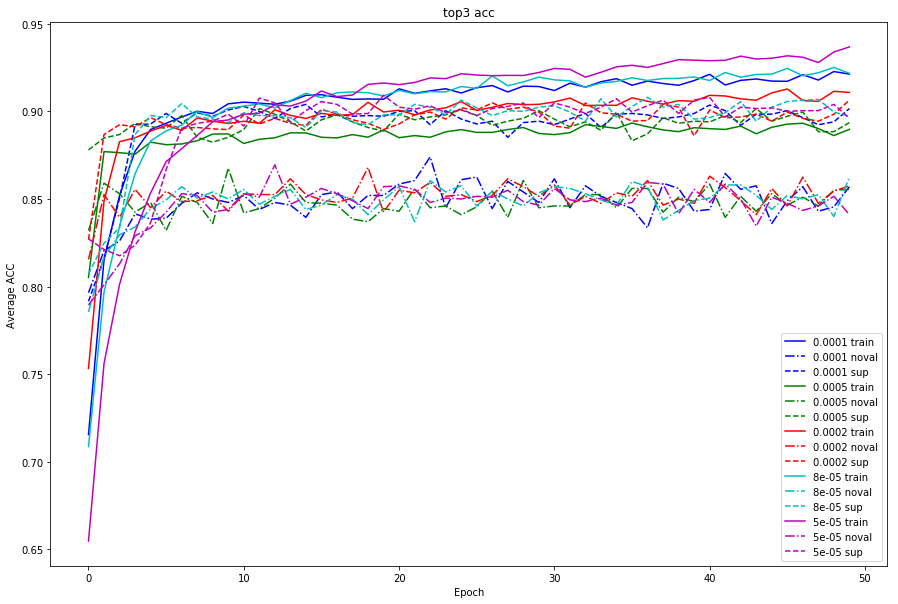

In [18]:
plot_acc(record)

## save record

In [20]:
import pickle
file = open('results/' + "text_device.pkl", "wb")
pickle.dump(record, file)
file.close()

## load record

In [39]:
with open('results/' + "text_device.pkl", 'rb') as f:
    temp = pickle.load(f)
    
path = 'Dataset/emotion/'
results = 'results/'

with open(path + 'label2idx.pkl', 'rb') as f:
    label2idx = pickle.load(f)

In [24]:
model_name = str(0.00008)
step=21

## get top1, top2, top3 accuracy

In [33]:
temp.NOVAL_ACC_1[model_name][step], temp.NOVAL_ACC_2[model_name][step], temp.NOVAL_ACC_3[model_name][step]

(0.2795, 0.601, 0.854)

In [34]:
temp.SUP_ACC_1[model_name][step], temp.SUP_ACC_2[model_name][step], temp.SUP_ACC_3[model_name][step] 

(0.55, 0.7712, 0.898)

# supprot dataset

In [36]:
y_true = temp.SUP_True_Labels[model_name][step]
y_pred = [i[0] for i in temp.SUP_Predicted_Labels[model_name][step]]

In [38]:
f1_score(y_true, y_pred, average='weighted')

0.5462134255736293

In [40]:
sup_df = pd.read_csv(path+'support.csv') 
all_answers = list(label2idx.keys())
sup_answers = [ i for i in all_answers if i in sup_df['label'].unique()]

In [42]:
import utils

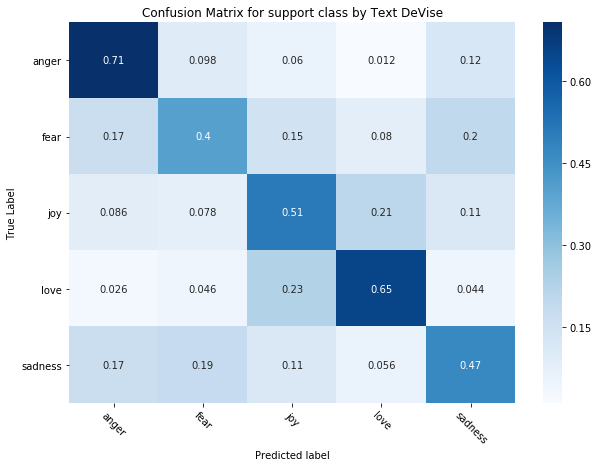

In [43]:
cm = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for support class by Text DeVise', 'tDeVise_cm_support', sup_answers)

## noval dataset

In [44]:
y_true = temp.NOVAL_True_Labels[model_name][step]
y_pred = [i[0] for i in temp.NOVAL_Predicted_Labels[model_name][step]]

In [45]:
f1_score(y_true, y_pred, average='weighted')

0.23504535380607774

In [48]:
noval_df = pd.read_csv(path+'noval.csv') 
all_answers = list(label2idx.keys())
noval_answers = [ i for i in all_answers if i in noval_df['label'].unique()]

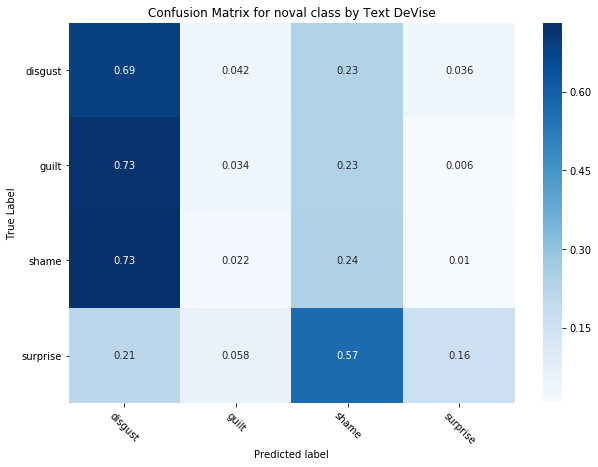

In [49]:
cm = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for noval class by Text DeVise', 'tDeVise_cm_noval', noval_answers)

## get t-sne of embedding

In [52]:
model =MLP().to(device)
lr = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
model_name = str(lr)
num_epoch = 20
num_negative_sampling = 8

trainer.run(model_name, num_epoch, record, model, optimizer, num_negative_sampling, train0_iter, sup_iter, noval_iter)

0.2483597695827484  


In [ ]:
import pickle
with open('Dataset/emotion/' + 'idx2label.pkl', 'rb') as f:
    idx2label = pickle.load(f)

In [93]:
from sklearn.manifold import TSNE

def get_embeddings(model, iterator):
    model.eval()
    sent_vecs = []
    embeddings = []
    labels = []    

    with torch.no_grad():
        for i, batch in enumerate(iterator):

            src= batch['sentvec']
            label = batch['label']
            batch_size = len(label)
            src, label = src.to(device), label.long().to(device)
            output = model.forward(src)

            embeddings.append(output.detach().cpu().numpy())
            labels.append(label.cpu().numpy())
            sent_vecs.append(src.cpu().numpy())

        embeddings = np.concatenate(embeddings, 0)
        sent_vecs = np.concatenate(sent_vecs, 0)
        labels = np.concatenate(labels)
        
        print(embeddings.shape, sent_vecs.shape, labels.shape)
        
        X_embedded = TSNE(n_components=2).fit_transform(np.array(embeddings))
        X_sent_vec = TSNE(n_components=2).fit_transform(np.array(sent_vecs))
        
        return X_embedded, X_sent_vec, labels

In [94]:
sup_embedded, sup_sent_vec, sup_labels = get_embeddings(model, sup_iter)
noval_embedded, noval_sent_vec, noval_labels = get_embeddings(model, noval_iter)

(2500, 300) (2500, 768) (2500,)
(2500, 300) (2500, 768) (2500,)
(2000, 300) (2000, 768) (2000,)
(2000, 300) (2000, 768) (2000,)


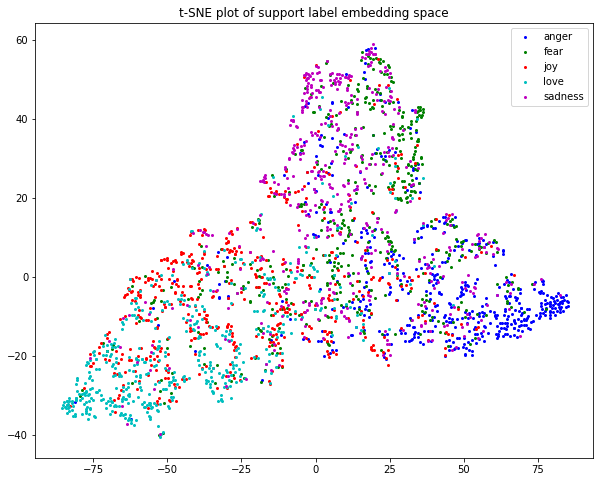

In [116]:
color_name = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'pink', 'skyblue', 'peru', 'orange', 'darkkahaki', 'plum' ]
label = np.unique(labels)

plt.figure(figsize=(10, 8))
for i in range(len(label)):
    plt.scatter(sup_embedded[sup_labels==label[i]][:,0], sup_embedded[sup_labels==label[i]][:, 1], c=color_name[i], s=4, label=idx2label[label[i]])
plt.legend()
plt.title('t-SNE plot of support label embedding space')
plt.savefig('results/tSNE_support_tDeVise.png', dpi=400)

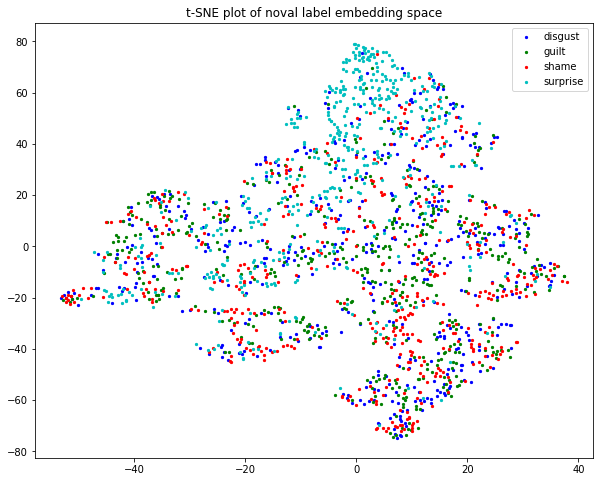

In [115]:
color_name = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'pink', 'skyblue', 'peru', 'orange', 'darkkahaki', 'plum' ]
label = np.unique(noval_labels)

plt.figure(figsize=(10,8))
for i in range(len(label)):
    plt.scatter(noval_embedded[noval_labels==label[i]][:,0], noval_embedded[noval_labels==label[i]][:, 1], c=color_name[i], s=5, label=idx2label[label[i]])
plt.legend()
plt.title('t-SNE plot of noval label embedding space')
plt.savefig('results/tSNE_noval_tDeVise.png', dpi=400)